My uncle died a few years ago from lung and intestinal cancer. It was a shock clearly, as I was eight thousand km away from him and the rest of the family. I couldn't even attend his funeral. Obviously, I felt unhelpfull and like I failed to get back home and be with my family.

That's why I decided to move forward and aim to help people in need and especially those who suffered like my uncle did. 

At the time I am writing this I am still working as a real estate accountant and while also shifting towards becoming a Machine Learning Engineer. I believe I can have a greater impact in this field because it’s something I’m passionate about !

This project is one my attempts to dive into AI and ML to acheive that goal. Readings like "Hands-On Machine Learning with Scikit-Learn, keras & Tensorflow" by Aurélien Géron, "Deep Learning with Python" by François Chollet and materials from Andrew Ng’s Coursera course have been invaluable in helping me build this project (and hopefully, much more).

Without further ado here is my Project 0 : Lung Cancer Classifier !

1. LOAD & PROCESS DATA

Explanation:

- The loop iterates through the folders and loads each image of our data
- The images are resized to 150x150 pixels, as CNNs require images of fixed size, I chose this as it is a generic size for this kind of treatment
- We convert the image data and labels into NumPy arrays for easier manipulation

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

data_dir = "/kaggle/input/lung-cancer-types/PROJET_CHOPPER_0/lung_cancer_data"
categories = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)  
    for img_name in tqdm(os.listdir(path), desc=f"Loading {category} images"):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)     
            img = cv2.resize(img, (150, 150)) 
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

data = np.array(data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Loading squamous_cell_carcinoma images: 100%|██████████| 5000/5000 [01:29<00:00, 55.77it/s]


X_train shape: (12000, 150, 150, 3), y_train shape: (12000,)
X_test shape: (3000, 150, 150, 3), y_test shape: (3000,)


2. IMAGE AUGMENTATION

Explanation:

- ImageDataGenerator helps to augment images on the fly creating slight variations to make the model more robust and helps us to gain more variety 
from our data
- To check if it worked well we visualize some sample

In [2]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (12000, 150, 150, 3)
y_train shape: (12000, 3)


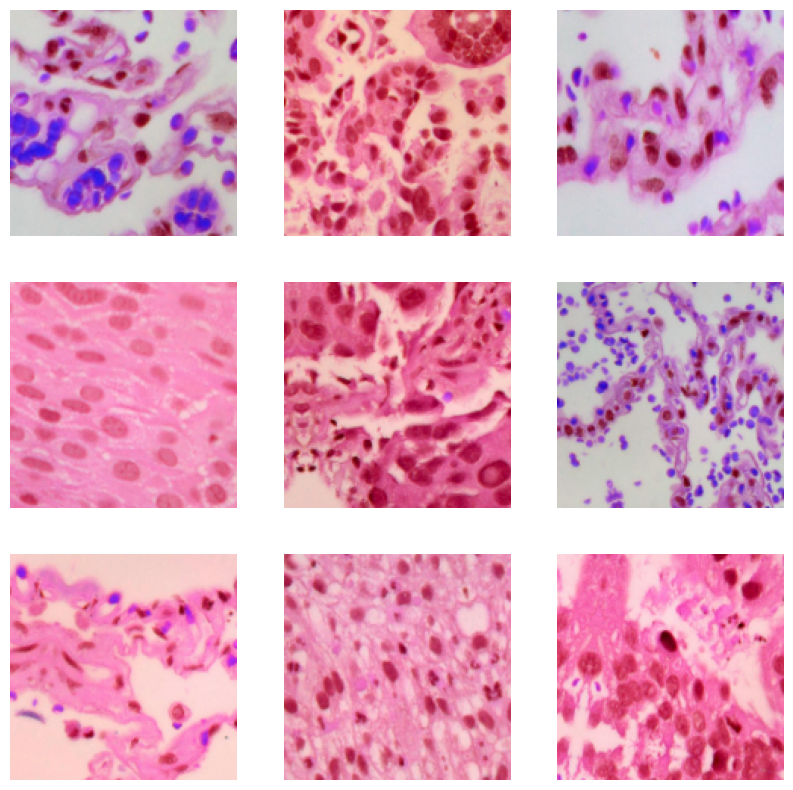

(12000, 3)
(3000, 3)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.09,
    zoom_range=0.09,
    horizontal_flip=True,
    fill_mode='reflect', 
)

train_gen = datagen.flow(X_train, y_train, batch_size=32)

X_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_batch[i])
    plt.axis('off') 

plt.show()

print(y_train.shape)
print(y_test.shape)



3. Building a CNN Model

Explanation:

- Three convolutional layers with ReLU activation extract features from our cell images
- MaxPooling2D reduces the dimensionality of the feature maps, making the model more efficient computationally
- A fully connected layer with 128 neurons followed by a dropout layer to prevent overfitting
- The last layer uses softmax to output probabilities for each class (adenocarcinoma, benign, squamous)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

# 1st Conv Layer
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), 
                 kernel_regularizer=l2(0.03)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Layer
model.add(Conv2D(32, (3, 3), activation='relu', 
                 kernel_regularizer=l2(0.03)))  
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Layer
model.add(Conv2D(64, (3, 3), activation='relu',
         kernel_regularizer=l2(0.03)))  
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(64, activation='relu',
         kernel_regularizer=l2(0.03)))  

model.add(Dropout(0.7))
model.add(Dense(3, activation='softmax'))

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,587 (4.61 MB)

 Trainable params: 1,207,587 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

4. Training the Model

- The model is trained for 50 epochs as it tends to overfit real quick
- I added an early stopping to prevent its overfitting

In [5]:
# Training model
history = model.fit(train_gen, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 152s 395ms/step - accuracy: 0.6446 - loss: 4.1489 - val_accuracy: 0.8287 - val_loss: 24.4594 - learning_rate: 1.0000e-04
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 150s 396ms/step - accuracy: 0.7753 - loss: 1.4606 - val_accuracy: 0.8473 - val_loss: 23.4879 - learning_rate: 1.0000e-04
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 148s 391ms/step - accuracy: 0.7858 - loss: 1.0871 - val_accuracy: 0.8487 - val_loss: 28.7446 - learning_rate: 1.0000e-04
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 150s 396ms/step - accuracy: 0.8010 - loss: 0.9335 - val_accuracy: 0.8567 - val_loss: 30.5768 - learning_rate: 1.0000e-04
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 150s 398ms/step - accuracy: 0.8204 - loss: 0.8522 - val_accuracy: 0.8430 - val_loss: 36.6462 - learning_rate: 1.0000e-04
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 150s 396ms/step - accuracy: 0.8203 - loss: 0.8128 - val_accuracy: 0.8437 - val_loss: 35.9621 - learning_rate: 1.0000e-04
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 148s 

5. Saving it for later purposes (comparing with other models and else)

In [6]:
model.save('/kaggle/working/my_custom_model_LCC.h5')


6. Incorporating pre-trained model

We will try some popular pre-trained models by transfer learning them and keep the one that performs best.

For this matter we will try MobileNetV2 and Resnet50. I thought about using VGG16 but finally let it down for its very expensive computationality

6.1. MobileNetV2
- Note that I exclude the top layers 

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

mobilenetv2_weights = "/kaggle/input/weights/weights.h5"

base_model = MobileNetV2(weights=mobilenetv2_weights, include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 6,354,499 (24.24 MB)

 Trainable params: 4,096,515 (15.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training the model with our initial data
Epochs to 20

In [9]:
train_gen = datagen.flow(X_train, y_train, batch_size=32)
history = model.fit(train_gen, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 160s 409ms/step - accuracy: 0.8326 - loss: 0.4831 - val_accuracy: 0.3233 - val_loss: 3.9491
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 393ms/step - accuracy: 0.9287 - loss: 0.1771 - val_accuracy: 0.3237 - val_loss: 3.9789
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 394ms/step - accuracy: 0.9331 - loss: 0.1688 - val_accuracy: 0.3233 - val_loss: 5.1041
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 395ms/step - accuracy: 0.9420 - loss: 0.1521 - val_accuracy: 0.3237 - val_loss: 6.0222
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 393ms/step - accuracy: 0.9483 - loss: 0.1355 - val_accuracy: 0.3233 - val_loss: 8.5943
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 149s 393ms/step - accuracy: 0.9516 - loss: 0.1247 - val_accuracy: 0.3233 - val_loss: 7.1522
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 393ms/step - accuracy: 0.9452 - loss: 0.1353 - val_accuracy: 0.3233 - val_loss: 7.8863
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 148s 391ms/step - accuracy: 0.9506 -

Interpretations:

Both models show overfitting but it's more obvious with MobileNetV2, especially on validation. My custom model on the other hand is more stable in terms of accuracy yet still has a high loss. And I also notice that the learning rate seems to be too high towards the end, which could block the progress of both models. So I might try to reduce it gradually with a scheduler.
For the overfitting, I'm thinking of adding dropout or L2 regularization to strengthen the model.

In short, MobileNetV2 performs well initially but doesn't generalize well and my custom model, on the other hand, has potential with a few adjustments.

The next step then would be to lower the learning rate and add regularization.